In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics


import dask
#dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
#from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# client = Client()
# client

In [3]:
E = ed.EsioData.load()
# Directories
runType='forecast'
updateall = False

In [4]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['IFD']}
updateAll = True
# Some models are terrible/have serious issues, so don't include in MME
MME_NO = ['hcmr']

In [5]:
# Target time range
valid_start = np.datetime64('2018-06-01')
valid_end = np.datetime64('2018-09-30')

In [6]:
# SIO Report Year_Month
cyear = '2018'
cmonth = 'July'

In [7]:
# Models that create an Ensemble using different init days
it_target_size = {'usnavysipn':10, 'ukmetofficesipn':21} # Define the number of past days to use TODO: assumes daily inits

In [8]:
# Define custom mod names
custom_names = {'usnavysipn':'NESM','gfdlsipn':'GFDL/NOAA','noaasipn':'NOAA CPC','uclsipn':'UCL','ukmetofficesipn':'Met Office','ecmwfsipn':'ECMWF-c3s'}

In [9]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in ['piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn']) ] # remove some models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['gfdlsipn',
 'yopp',
 'ukmetofficesipn',
 'ecmwf',
 'metreofr',
 'ukmo',
 'kma',
 'ncep',
 'usnavysipn',
 'usnavyncep',
 'rasmesrl',
 'noaasipn',
 'noaasipn_ext',
 'uclsipn',
 'szapirosipn',
 'awispin',
 'nicosipn',
 'usnavygofs']

In [10]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [11]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited IFD data

In [12]:
user_ifd = [] # Dictionary to store user submitted (regridded) SIP data
r_yr_mon = cyear+'_'+cmonth
mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}

### npssipn (RASM)

In [13]:
# cmod = 'RASM'
# sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Junreportdata.nc'
# # Open
# ds_user = xr.open_dataset(sip_f)
# #ds_user.SIP_ID.plot()
# # Regrid/format to sipn
# ds_user.rename({'lat':'nj', 'long':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
# ds_user.set_coords(['lat','lon'], inplace=True)
# # Select SIP
# da_in = ds_user.SIP_ID
# mask = ds_user.Grid_Area.notnull()
# da_in = da_in.where(mask)



# # Calculate regridding matrix
# regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# # Regrid 
# da_out = regridder(da_in)
# # Remove weight file
# regridder.clean_weight_file() 
# # da_in.plot()
# # plt.figure()
# # da_out.plot()

# # Store in dict of user submited SIP
# da_out.coords['model'] = cmod
# user_ifd.append(da_out)

In [14]:
pd.to_datetime('2018-06-01').timetuple().tm_yday

152

### cansips (Mod CanSIPS)

273.0
181.0
Create weight file: nearest_s2d_18x128_304x448.nc
Remove file nearest_s2d_18x128_304x448.nc


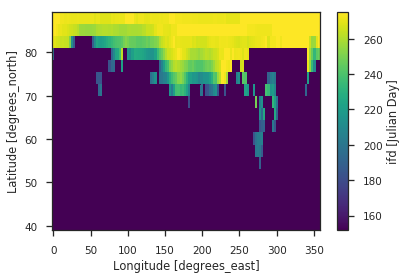

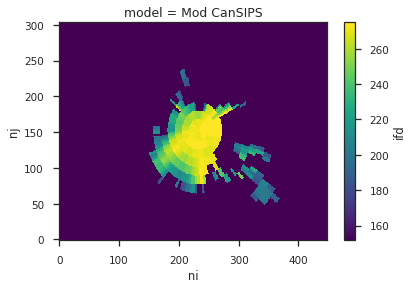

In [15]:
cmod = 'Mod CanSIPS'

if r_yr_mon=='2018_June':
    sip_f = '/home/disk/sipn/upload/ecsipn/June_2018_fix/ifd_bc_i2018m06_Mod_CanSIPS.nc'
elif r_yr_mon=='2018_July':
    sip_f = '/home/disk/sipn/upload/ecsipn/July_2018/ifd_bc_i2018m07_Mod_CanSIPS.nc'
elif r_yr_mon=='2018_August':
    sip_f = '/home/disk/sipn/upload/ecsipn/August_2018/ifd_bc_i2018m08_Mod_CanSIPS.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")

ds_user = xr.open_dataset(sip_f, drop_variables='time')
ds_user.rename({'longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
da_in = ds_user.ifd
print(da_in.max().values)
print(da_in.min().values)

# Set never melts to first valeus (to be consistent with how sipn does it)
# da_in = da_in.where(da_in<da_in.max().values, other=da_in.min().values)
# Set pernial to 275
da_in = da_in.where(da_in<da_in.max().values, other=275)

# Set pixels that are ice free at init, to -9999
da_in = da_in.where(da_in!=da_in.min().values, other=152) #pd.to_datetime('2018-06-01').timetuple().tm_yday)

# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 

# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_ifd.append(da_out)

plt.figure()
da_in.plot()
plt.figure()
da_out.plot()

### nrlsipn (NESM)

In [16]:
# cmod = 'NESM'

# if r_yr_mon=='2018_June':
#     sip_f = '/home/disk/sipn/nicway/data/model/usnavysipn/forecast/metrics_from_nrl/NESM_Sep2018_Maydata_IFD_common.nc'
# elif r_yr_mon=='2018_July':
#     sip_f = ''
# else:
#     raise ValueError(r_yr_mon,"not found, add sip_f path.")

# if 
# ds_user = xr.open_dataset(sip_f)
# ds_user.rename({'Longitude':'lon','Latitude':'lat'}, inplace=True);
# # Select SIP
# da_in = ds_user.IFD.isel(MT=0)
# da_in 

# # Calculate regridding matrix
# regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
# # Regrid 
# da_out = regridder(da_in)
# # Remove weight file
# regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()
# # Store in dict of user submited SIP
# da_out.coords['model'] = cmod
# print("Not adding User submited NESM here, Joe wanted us to use our own calculated one")
# #user_ifd.append(da_out)


### GMAO

Create weight file: nearest_s2d_448x304_304x448_peri.nc
Remove file nearest_s2d_448x304_304x448_peri.nc


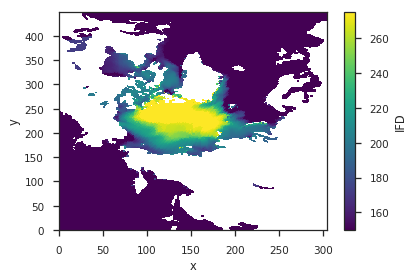

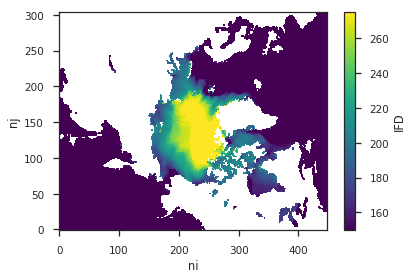

In [17]:
cmod = 'GMAO'

if r_yr_mon=='2018_June':
    sip_f = ''
elif r_yr_mon=='2018_July':
    sip_f = '/home/disk/sipn/nicway/data/model/gmao/gmao_Sep2018_Julydata_IFD_thatssmigrid.nc4'
    #maskf = '/home/disk/sipn/nicway/data/model/gmao/gmao_Sep2018_Julydata_SIP_thatssmigrid.nc4'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")


if sip_f:
    ds_user = xr.open_dataset(sip_f)
    landmask = ds_user.IFD.notnull()
    
    # Mask
    ds_user = ds_user.set_coords(['LAT','LON'])

    da_in = ds_user.rename({'LON':'lon','LAT':'lat'}).IFD
    
    # Set never melts to first valeus (to be consistent with how sipn does it)
    da_in = da_in.where(da_in<da_in.max().values, other=275)
    
    da_in = da_in.where(landmask)
    

    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    
    da_in.plot()
    plt.figure()
    da_out.plot()
    
    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    user_ifd.append(da_out)

In [18]:
# Concat them together by model
usr_IFD = xr.concat(user_ifd, dim='model')
usr_IFD = usr_IFD.rename({'nj':'x', 'ni':'y'})
usr_IFD.name = 'IFD'
usr_IFD

<xarray.DataArray 'IFD' (model: 2, x: 304, y: 448)>
array([[[152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.],
        ...,
        [152., 152., ..., 152., 152.],
        [152., 152., ..., 152., 152.]],

       [[150., 150., ...,  nan,  nan],
        [150., 150., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 150., 150.],
        [ nan,  nan, ..., 150., 150.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) <U11 'Mod CanSIPS' 'GMAO'
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

In [19]:
# Define the last init day as the 11th of the current month's report (i.e. June would be the 11th of June)
last_init_day = np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth],11))
# Define the earliest init day as 1 year before last_init_day ( some models init on 1st of month (i.e. UCL))
first_init_day = np.datetime64(datetime.datetime(int(cyear),1,1))-np.timedelta64(2,'D')    # last_init_day-np.timedelta64(365,'D')
print("Looking for init times between",first_init_day,"and",last_init_day)

Looking for init times between 2017-12-30T00:00:00.000000 and 2018-07-11T00:00:00.000000


In [20]:
for cvar in variables:
    
    # Define fig dir and make if doesn't exist
    fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
       
    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:

        MME_list = []      
    
        # For each model
        for (i, cmod) in enumerate(models_2_plot): # ['nicosipn']
            print(cmod)

            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc') 

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model
            
            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

            # Restrictions for calculating IFD
            
            # 1) Must be Daily or less
            c_dt = (ds_model.fore_time[1]-ds_model.fore_time[0]).values.astype('timedelta64[D]').astype('int')
            if c_dt > 1:
                print("    fore_time timestep greater than 1 day, skipping.")
                continue
            
            # Select var of interest (if available)
            if cvar in ds_model.variables:
                ds_model = ds_model[cvar]
            else:
                print('    cvar not found.')
                continue
                  
            # Use lagged ensemble
            if cmod in list(it_target_size.keys()): # Uses a lagged ensemble... so grab all inits and make them ensembles
                
                # NESM (Joe) wants us to use the past months inits (June for July report)
                if cmod == 'usnavysipn':
                    # Replace last_init_day inline below (note the "-1" meaning last month)
                    ds_model = ds_model.sel(init_time=slice(first_init_day,  np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth] - 1, 11))  )) # First get all time between start and stop (up to and including the 10th)
                else:
                    ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                    
                print("    Init times used are",ds_model.init_time[-1*it_target_size[cmod]:].values)    
                
                ds_model = ds_model.sel(init_time=ds_model.init_time[-1*it_target_size[cmod]:]) # Get nearest date to 10th
                avg_init_time = ds_model.init_time.astype('int').median().astype('datetime64[ns]')
                ds_model = ds_model.stack(hybrid_ensemble=('ensemble', 'init_time')).reset_index('hybrid_ensemble')
                ds_model.coords['hybrid_ensemble'] = np.arange(1,ds_model.hybrid_ensemble.size+1,1)
                ds_model = ds_model.drop(['ensemble','init_time'])
                ds_model.coords['init_time'] = avg_init_time
                ds_model = ds_model.rename({'hybrid_ensemble':'ensemble'})
                print(ds_model)

            # Normal Ensemble
            else:
                # Find init time closest and earlier to the 10th of the month
                ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                ds_model = ds_model.sel(init_time=last_init_day, method='nearest') # Get nearest date to 10th
                
            print("    Init time used is", ds_model.init_time.values)
            
            
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                           
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("    No fore_time found for target period.")
                continue
                
            # 2) Must have a forecast that goes until end of sept.
            last_f = ds_model.valid_time.max()
            if last_f < valid_end - np.timedelta64(20,'D'): # allow 5 days wiggle room
                print('    Last Valid time', last_f.values, ' was not within 20 days of target end ', valid_end)
                continue
                
            # Averave SIC over ensembles
            ds_model = ds_model.mean(dim='ensemble')
            ds_model.load()
                
            # Calculate IFD
            print("    Calculating IFD")
#             if cmod=='nicosipn':
#                 xr.exit()
            DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
            ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                            Nday=10, default_ice_free=pd.to_datetime('2018-06-01').timetuple().tm_yday)

            # Build MME
            ds_idf = ds_ifd.isel(init_time=0).drop('init_time')

            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_ifd.coords['model'] = cmod
                MME_list.append(ds_ifd)
                print('    Added ', cmod, ' to MME.')


# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'IFD'

gfdlsipn
    Init time used is 2018-07-01T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  gfdlsipn  to MME.
yopp
    Init time used is 2018-07-11T00:00:00.000000000
    Last Valid time 2018-07-26T00:00:00.000000000  was not within 20 days of target end  2018-09-30
ukmetofficesipn
    Init times used are ['2018-06-11T00:00:00.000000000' '2018-06-12T00:00:00.000000000'
 '2018-06-13T00:00:00.000000000' '2018-06-14T00:00:00.000000000'
 '2018-06-15T00:00:00.000000000' '2018-06-16T00:00:00.000000000'
 '2018-06-17T00:00:00.000000000' '2018-06-18T00:00:00.000000000'
 '2018-06-19T00:00:00.000000000' '2018-06-20T00:00:00.000000000'
 '2018-06-21T00:00:00.000000000' '2018-06-22T00:00:00.000000000'
 '2018-06-23T00:00:00.000000000' '2018-06-24T00:00:00.000000000'
 '2018-06-25T00:00:00.000000000' '2018-06-26T00:00:00.000000000'
 '2018-06-27T00:00:00.000000000' '2018-06-28T00:00:00.000000000'
 '2018-06-29T00:00:00.000000000' '2018-06-30T00:00:00.000000000'
 '2018-07-01T00:00:00.000000000']
<xarray.DataArray 'sic' (fore_time: 215, x: 304, y: 448, ensemble: 147

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  ukmetofficesipn  to MME.
ecmwf
    Init time used is 2018-06-25T00:00:00.000000000
    Last Valid time 2018-08-10T00:00:00.000000000  was not within 20 days of target end  2018-09-30
metreofr
    Init time used is 2018-06-21T00:00:00.000000000
    Last Valid time 2018-07-23T00:00:00.000000000  was not within 20 days of target end  2018-09-30
ukmo
    Init time used is 2018-06-26T00:00:00.000000000
    Last Valid time 2018-08-25T00:00:00.000000000  was not within 20 days of target end  2018-09-30
kma
    Init time used is 2018-06-26T00:00:00.000000000
    Last Valid time 2018-08-25T00:00:00.000000000  was not within 20 days of target end  2018-09-30
ncep
    Init time used is 2018-06-26T00:00:00.000000000
    Last Valid time 2018-08-09T00:00:00.000000000  was not within 20 days of target end  2018-09-30
usnavysipn
    Init times used are ['2018-05-10T12:00:00.000000000' '2018-06-02T12:00:00.000000000'
 '2018-06-03T12:00:00.000000000' '2018-06-04T12:00:00.0

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  usnavysipn  to MME.
usnavyncep
    Init time used is 2018-07-03T12:00:00.000000000
    Last Valid time 2018-08-17T00:00:00.000000000  was not within 20 days of target end  2018-09-30
rasmesrl
    Init time used is 2018-07-10T00:00:00.000000000
    Last Valid time 2018-07-20T00:00:00.000000000  was not within 20 days of target end  2018-09-30
noaasipn
    Init time used is 2018-06-25T00:00:00.000000000
    Last Valid time 2018-09-01T00:00:00.000000000  was not within 20 days of target end  2018-09-30
noaasipn_ext
uclsipn
    Init time used is 2018-01-01T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  uclsipn  to MME.
szapirosipn
    Init time used is 2018-06-30T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  szapirosipn  to MME.
awispin
    Init time used is 2018-07-09T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  awispin  to MME.
nicosipn
    Init time used is 2018-06-01T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


    Calculating IFD
    Added  nicosipn  to MME.
usnavygofs


In [21]:
# DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
# ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
#                                 Nday=10, default_ice_free=pd.to_datetime('2018-06-01').timetuple().tm_yday)
# print(ds_ifd.where(ds_ifd<275).max().values)
# plt.figure()
# ds_ifd.isel(init_time=0).plot(vmin=153,vmax=274)

In [22]:
# Take mean
model_inits = ds_MME.init_time.values
ds_MME = ds_MME.mean(dim='init_time')
ds_MME

<xarray.DataArray 'IFD' (model: 7, x: 304, y: 448)>
array([[[152., 152., ...,  nan,  nan],
        [152., 152., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 152., 152.],
        [ nan,  nan, ..., 152., 152.]],

       [[152., 152., ...,  nan,  nan],
        [152., 152., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 152., 152.],
        [ nan,  nan, ..., 152., 152.]],

       ...,

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[152., 152., ...,  nan,  nan],
        [152., 152., ...,  nan,  nan],
        ...,
        [ nan,  nan, ..., 152., 152.],
        [ nan,  nan, ..., 152., 152.]]])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ..

In [23]:
# Merge user SIP with SPIN SIP
ds_IFD_All = xr.concat([ds_MME, usr_IFD], dim='model')

In [24]:
# Load into memory
ds_IFD_All.load();

In [25]:
# Save to disk
ds_IFD_All.to_netcdf('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/IFD.nc')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [26]:
# Get mean and std of all models (set -9999 (ice free at init) and perenial ice (275) to missing))
ds_MME_avg = ds_IFD_All.mean(dim='model') #.where((ds_IFD_All>1) & (ds_IFD_All<275))
ds_MME_std = ds_IFD_All.std(dim='model')

In [27]:
c_vmin = [x.timetuple().tm_yday for x in [pd.datetime(2018,6,1)]][0]
c_vmax = [x.timetuple().tm_yday for x in [pd.datetime(2018,10,1)]][0]

In [28]:
# Get dates for plot
last_IFD = pd.to_datetime((np.datetime64('2018-01-01') + np.timedelta64(int(c_vmax),'D')))
date_str = pd.to_datetime(datetime.datetime(2018, 6, 1)).strftime('%Y-%m-%d')

In [29]:
# Get monthly ticks
DOY_months = [x.timetuple().tm_yday for x in pd.date_range(date_str,'2018-10-30', freq='MS')]
DOY_labels = [calendar.month_abbr[mn]+' 1' for mn in np.arange(6,last_IFD.month+1)]
assert len(DOY_months)==len(DOY_labels)

In [30]:
ds_IFD_All.loc[dict(model='Mod CanSIPS')] = ds_IFD_All.sel(model='Mod CanSIPS').where(ds_IFD_All.isel(model=0).notnull())
ds_MME_std = ds_MME_std.where(ds_IFD_All.isel(model=0).notnull())

gfdlsipn
ukmetofficesipn
usnavysipn
uclsipn
szapirosipn
awispin
nicosipn
Mod CanSIPS
GMAO
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2018/July/panArctic_IFD_forecast_2018_July_plus_std_lowRes.png


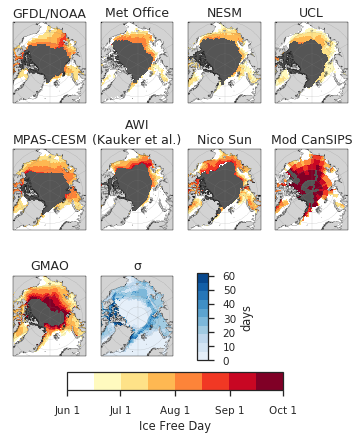

In [31]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1
    elif metric=='IFD':
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=8)
#         cmap_c.set_bad(color = 'lightgrey')
        
        cfile = '/home/disk/sipn/nicway/python/ESIO/notebooks/color_redhues.mat'
        import scipy.io
        matfile = scipy.io.loadmat(cfile)
        redhues = matfile['redhues']
        # add perenial ice color (black)
        #redhues_b = np.concatenate((redhues,np.array([[0,0,0]])),axis=0)
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_c.set_bad(color = 'lightgrey')
        
        #cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_std = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
        cmap_std.set_bad(color = 'lightgrey')
        
        cmap_b =  matplotlib.colors.ListedColormap(sns.color_palette("binary", 2))
        cmap_b.set_bad(color = 'None')
        
        c_label = 'Ice Free Day'


elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=3, Nplots=ds_IFD_All.model.size + 1 + 1, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_IFD_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_IFD_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    # Plot perenial ice as black
    cper_mask = ds_IFD_All.sel(model=cmod)
    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

# MME Standard deviation
i = i + 1


pstd = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
# cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.55, 0.07, .025, .20]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std_lowRes.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [32]:
model_inits

array(['2018-01-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-06-06T00:00:00.000000000', '2018-06-21T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-07-09T00:00:00.000000000'], dtype='datetime64[ns]')

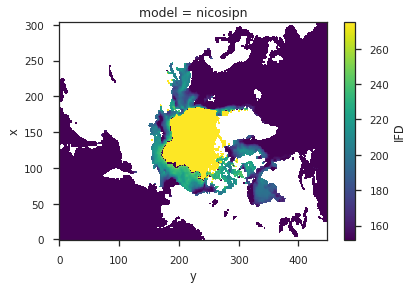

In [33]:
ds_IFD_All.sel(model='nicosipn').plot()

In [34]:
# Old code for figure without the std

In [35]:
# # Set up plotting info
# if cvar=='sic':
#     if metric=='mean':
#         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
#         cmap_c.set_bad(color = 'lightgrey')
#         c_label = 'Sea Ice Concentration (-)'
#         c_vmin = 0
#         c_vmax = 1
#     elif metric=='SIP':
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
#         cmap_c.set_bad(color = 'lightgrey')
#         c_label = 'Sea Ice Probability (-)'
#         c_vmin = 0
#         c_vmax = 1
#     elif metric=='anomaly':
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
#         cmap_c.set_bad(color = 'lightgrey')
#         c_label = 'SIC Anomaly to 1980-2010 Mean'
#         c_vmin = -1
#         c_vmax = 1
#     elif metric=='IFD':
#         cfile = '/home/disk/sipn/nicway/python/ESIO/notebooks/color_redhues.mat'
#         import scipy.io
#         matfile = scipy.io.loadmat(cfile)
#         redhues = matfile['redhues']
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
#         cmap_c.set_bad(color = 'lightgrey')
#         c_label = 'Ice Free Day'


# elif cvar=='hi':
#     if metric=='mean':
#         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
#         cmap_c.set_bad(color = 'lightgrey')
#         c_label = 'Sea Ice Thickness (m)'
#         c_vmin = 0
#         c_vmax = None
# else:
#     raise ValueError("cvar not found.") 


    
# def add_subplot_title(cmod, custom_names, E, ax=None):
#     if cmod in custom_names:
#         ax.set_title(custom_names[cmod])
#     elif cmod in E.model.keys():
#         ax.set_title(E.model[cmod]['model_label'])
#     else:
#         ax.set_title(cmod)

# # New Plot
# central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
# (f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=2, Nplots=8, extent=central_extent, central_longitude=0)

# for (i, cmod) in enumerate(ds_IFD_All.model.values):
#     print(cmod)
#     # Plot
#     add_subplot_title(cmod, custom_names, E, ax=axes[i])
#     p = ds_IFD_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False,
#                           cmap=cmap_c,
#                           vmin=c_vmin, vmax=c_vmax)
#     add_subplot_title(cmod, custom_names, E, ax=axes[i])

# # Make pretty
# f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
# cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)

# # Save to file
# f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
# f.savefig(f_out,bbox_inches='tight', dpi=200)
# print("saved ", f_out)